In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [37]:
print(np.random.binomial(1, 0.5, 10))

[0 0 1 1 1 1 1 1 0 0]


# K-Arm Bandit Model
Includes:
*   Plot Code (Q2,Q3--Plot Code for Q4 Onwards Below)
*   Action-Value Update Methods
*   E-Greedy Algorithm Method, with UCB Algorithm Option
*   Thompson Sampling Algorithm (No E-Greedy)





In [52]:
# QUESTION 1 

class bernouilliBandit:
  def __init__(self, k, p):
    self.k = k
    self.p = p
    self.rewards = np.zeros((self.k))
    self.explored = np.ones((self.k))
    self.si = np.ones((self.k)) 
    self.fi = np.ones((self.k)) 
    
    # check if length of p == k
  
  def sample(self, index):
    output = np.random.binomial(1,self.p[index],1)
    return output
    # return reward from action index (outputing at bernouilli)
  
  def generate(self, num): # output list
    set = np.zeros((self.k, num))
    for i in range(self.k):
      for j in range(num):
        set[i,j]=self.sample(i)
    return set
  
  def plot1(self, num):
    results = self.generate(num)

    time = np.arange(results.shape[1]) + 1 # do we need a +1 increment?

    empmean = np.zeros(results.shape)
    for arm in range(self.k): # we may replace this with k later...
      empmean[arm] = np.cumsum(results[arm])/time
    
    q = np.repeat(probs.reshape(3,1), 50, axis=1)

    figure, axis = plt.subplots(3,1, figsize=(10,10))

    for arm in range(self.k):
      axis[arm].plot(time, results[arm], label='Reward')
      axis[arm].plot(time, empmean[arm], label='Empirical Cumulative Mean') # note that this is cumulative
      axis[arm].plot(time, q[arm], label='q*')
      axis[arm].set_title("Action " + str(arm) + ", Probability " + str(self.p[arm]))
    
    plt.legend()
    plt.show()

# QUESTION 2

# Let us assume the question is referring to the exponential recency-weighted avg

  def update(self, results, arm, n, alpha): # either full results sliced until n or n results 
    # note that we are estimating the action value at n + 1!
    actval = (1-alpha)**n * results[arm,0] # or whatever the initial action value is
    for i in range(1, n+1):
      actval += alpha * (1 - alpha)**(n-i) * results[arm,i]
    return actval

  def updateAvg(self, new, mean, alpha):
    return mean + alpha*(new-mean)

  # previous two functions essentially perform the same function

  def plot2(self, num, alphas): # list of alphas, not just one alpha!
    results = self.generate(num)

    time = np.arange(results.shape[1]) + 1 # do we need a +1 increment?

    empmean = np.zeros(results.shape)
    for arm in range(self.k): # we may replace this with k later...
      empmean[arm] = np.cumsum(results[arm])/time

    weightmeans = [] # list of alphas

    for alpha in alphas:
      weightmean = np.zeros(results.shape)
      for arm in range(self.k): # we may replace this with k later...
        weightmean[arm,0] = self.update(results, arm, 0, alpha)
        for i in range(1, results.shape[1]):
          weightmean[arm,i] = self.updateAvg(results[arm,i], weightmean[arm,i-1], alpha)
      weightmeans.append(weightmean)
    
    q = np.repeat(probs.reshape(3,1), num, axis=1)

    figure, axis = plt.subplots(3,1, figsize=(10,10))

    for arm in range(self.k):
      #axis[arm].plot(time, results[arm], label='Reward')
      axis[arm].plot(time, empmean[arm], label='Empirical Cumulative Mean') # note that this is cumulative
      for i, weightmean in enumerate(weightmeans):
        axis[arm].plot(time, weightmean[arm], label='Alpha = ' + str(alphas[i]))
      axis[arm].plot(time, q[arm], label='q*')
      axis[arm].set_title("Action " + str(arm) + ", Probability " + str(self.p[arm]))
    
    plt.legend()
    plt.show()

# QUESTION 3

  def plot3(self, num, alphas): 
    results = self.generate(num)

    time = np.arange(results.shape[1]) + 1 

    empmean = np.zeros(results.shape)
    for arm in range(self.k): 
      empmean[arm] = np.cumsum(results[arm])/time

    weightmeans = [] 

    for alpha in alphas:
      weightmean = np.zeros(results.shape)
      for arm in range(self.k): 
        weightmean[arm,0] = 0 # THIS INITIALIZES IT TO 0?
        for i in range(1, results.shape[1]):
          weightmean[arm,i] = self.updateAvg(results[arm,i], weightmean[arm,i-1], alpha)
      weightmeans.append(weightmean)
    
    q = np.repeat(probs.reshape(3,1), num, axis=1)

    figure, axis = plt.subplots(3,1, figsize=(10,10))

    for arm in range(self.k):
      axis[arm].plot(time, empmean[arm], label='Empirical Cumulative Mean') 
      for i, weightmean in enumerate(weightmeans):
        axis[arm].plot(time, weightmean[arm], label='Alpha = ' + str(alphas[i]))
      axis[arm].plot(time, q[arm], label='q*')
      axis[arm].set_title("Action " + str(arm) + ", Probability " + str(self.p[arm]))
    
    plt.legend()
    plt.show()

  def greedy(self, num, epsilon, alpha=-1, c=0):
    # this counts the number of times for each action

    results = np.zeros(num) # results over time

    optrate = np.zeros(num) # cum sum divided by 100 runs
    insregrets = np.zeros(num) # value - current best action value

    if c==0:
      for i in range(num): 
        exploit = np.where(self.rewards == self.rewards.max(axis=0))[0] # first index of array of maxes

        if exploit[0]==0:
          optrate[i] = 1
        else:
          optrate[i] = 0

        if random.random() < epsilon:
          choice = np.random.randint(0, self.k)
        else:
          choice = np.random.randint(0, exploit.shape[0])
          choice = exploit[choice]

        output = self.sample(choice)

        if alpha==-1:
          self.rewards[choice] = self.updateAvg(output, self.rewards[choice], 1/(i+1)) # where 1/i is like normal avging
        else:
          self.rewards[choice] = self.updateAvg(output, self.rewards[choice], alpha)

        insregret = self.rewards.max(axis=0) - self.rewards[choice] # calculate regret before or after?

        results[i] = output
        insregrets[i] = insregret
    
    else:

      for i in range(self.k):
        exploit = np.where(self.rewards == self.rewards.max(axis=0))[0]

        if exploit[0]==0:
          numoptimal=1
        else:
          numoptimal=0
        
        output = self.sample(i)

        if alpha==-1:
          self.rewards[i] = self.updateAvg(output, self.rewards[i], 1/(i+1)) # where 1/i is like normal avging
        else:
          self.rewards[i] = self.updateAvg(output, self.rewards[i], alpha)

        insregret = self.rewards.max(axis=0) - self.rewards[i] # calculate regret before or after?
        results[i] = output
        optrate[i] = numoptimal
        insregrets[i] = insregret
      
      for i in range(self.k-1, num): 
        newrewards = self.rewards + self.ucb(c)
        exploit = np.where(newrewards == newrewards.max(axis=0))[0] # first index of array of maxes

        if exploit[0]==0:
          numoptimal=1
        else:
          numoptimal=0

        if random.random() < epsilon:
          choice = np.random.randint(0, self.k)
        else:
          choice = np.random.randint(0, exploit.shape[0])
          choice = exploit[choice]

        self.explored[choice] += 1 # update the explored array for UCB

        output = self.sample(choice)

        if alpha==-1:
          self.rewards[choice] = self.updateAvg(output, self.rewards[choice], 1/(i+1)) # where 1/i is like normal avging
        else:
          self.rewards[choice] = self.updateAvg(output, self.rewards[choice], alpha)

        insregret = self.rewards.max(axis=0) - self.rewards[choice] # calculate regret before or after?

        results[i] = output
        optrate[i] = numoptimal
        insregrets[i] = insregret
      
    return results, optrate, insregrets


  # QUESTION 6
  
  def ucb(self, c):
    return c * np.sqrt(np.repeat(2 * np.log(i+1), self.k)/self.explored)


  # QUESTION 7 

  def thompson(self, num, epsilon, alpha=-1): # without UCB, but why?

    results = np.zeros(num) # results over time
    numoptimal = 0 # num of times the optimal action value was the first one
    optrate = np.zeros(num) # cum sum divided by 100 runs
    insregrets = np.zeros(num) # value - current best action value

    sampling = np.zeros(self.k)

    for i in range(num): 
      for j in range(self.k):
        sampling[j] = np.random.beta(self.si[j], self.fi[j])

      exploit = np.where(sampling == sampling.max(axis=0))[0] # first index of array of maxes

      if exploit[0]==0:
        numoptimal=1
      else:
        numoptimal=0

      if random.random() < epsilon:
        choice = np.random.randint(0, self.k)
      else:
        choice = np.random.randint(0, exploit.shape[0])
        choice = exploit[choice] # random int in the array of maxes

      output = self.sample(choice)

      if alpha==-1:
        if output==1:
          self.si[choice] += 1  
        else:
          self.fi[choice] += 1
      else:
        if output==1:
          self.si[choice] = self.updateAvg(output, self.si[choice], alpha) 
        else:
          self.fi[choice] = self.updateAvg(output, self.fi[choice], alpha) 

      insregret = sampling.max(axis=0) - sampling[choice] # calculate regret before or after?

      results[i] = output
      optrate[i] = numoptimal
      insregrets[i] = insregret
      
    return results, optrate, insregrets

#Q1-Q3

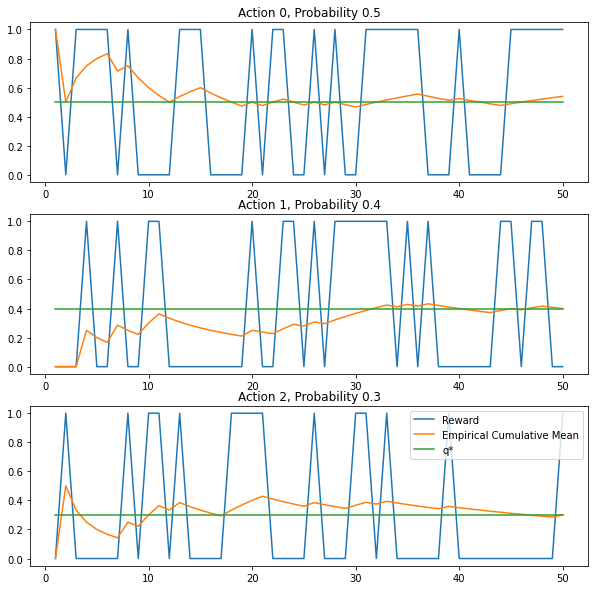

In [39]:
# QUESTION 1

d = 0.1
probs = np.array([0.5, 0.5-d, 0.5-2*d])

model = bernouilliBandit(3, probs)
results = model.generate(50)
model.plot1(50)

# how to enforce a random seed again?

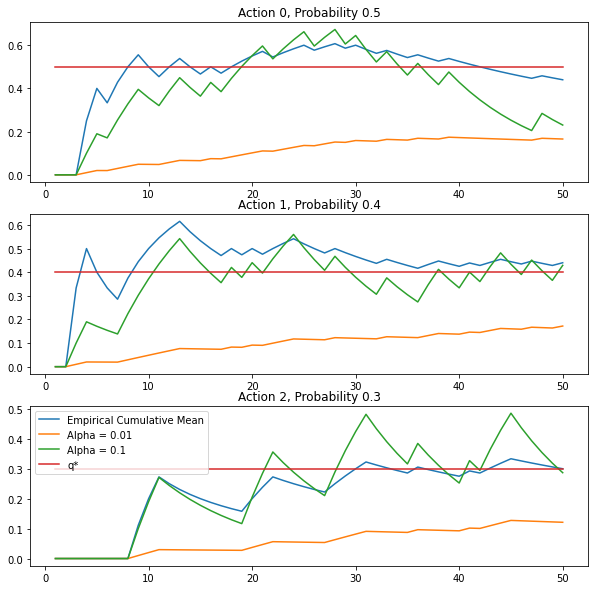

In [40]:
# QUESTION 2

alphas = [0.01, 0.1]

model.plot2(50, alphas)

The lower the alpha, the more the action value is affected by the initial values...

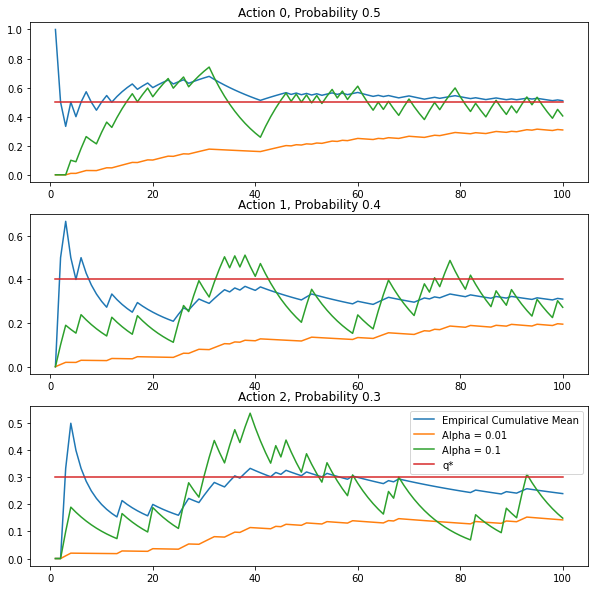

In [41]:
# QUESTION 3

# Repeat the above experiment 100 times, starting with action value estimates of 0
# How to initialize action value estimates of 0?

model.plot3(100, alphas)

*Which of the α values is better? How do they compare to averaging? If you wanted to optimize further, in what range of α would you look for better values?*

At alpha = 0.01, the recency weighted mean converges slowly to true value. This is because intuitively, the smaller weight casts a further "look" back into previous trials, where the success/fail rate is stable and comprehensively approximates the true value. 

At alpha = 0.1, on the other hand, the recency weighted mean is very shaky, as it is excessively affected by the stochasticity of more recent trials.

I suggest that the variance ("gap" between expected value and possible values) and the number of trials are at play here. Due to the extremal nature of the possible values (0 and 1), any estimated action value that is either too low or too high will experience a fluctuation whenever a respectively high or low reward is received. This is why as we look down the plots (from 0.5 down to 0.3), the curves appear shakier and shakier. 

However, given we cannot change the model (it is independent), we can only either decrease alpha or increase the number of runs to "smoothen" out the k-arm bandit's estimations.

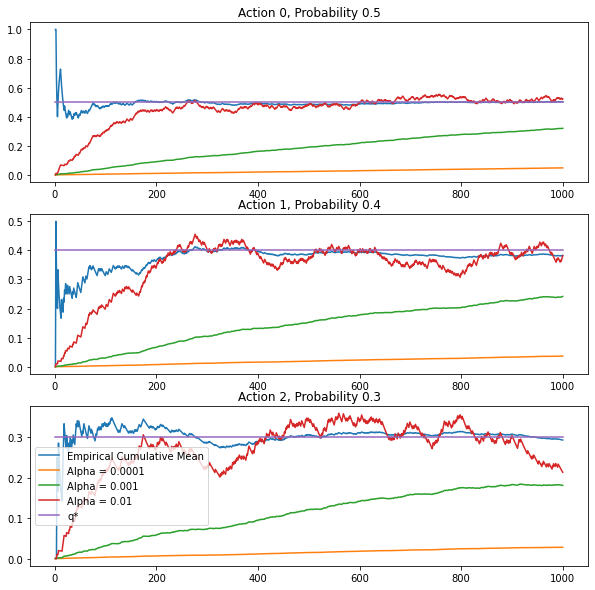

In [43]:
# It seems that 0.0001 and 0.001 is too slow at 100, so let's try at 1000

alphas2 = [0.0001, 0.001,0.01]

model.plot3(1000, alphas2)

# Generally, once the action value finishes converging to true value, it starts fluctuating...

# Q4. E-Greedy Algorithm + Plot 

In [44]:
results, optrate, regret = model.greedy(50, 0.5)

print(optrate)

[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [45]:
steps = 1000
runs = 100
epsilons = [0, 1/8, 1/4, 1/2, 1]

def greedyrun(steps, runs, epsilon, alpha=-1, c=0):
  resultsavg = np.zeros(steps)
  optrateavg = np.zeros(steps)
  regretavg = np.zeros(steps)

  for run in range(runs):
    results, optrate, regret = model.greedy(steps, epsilon, alpha, c)
    resultsavg += results
    optrateavg += optrate
    regretavg += regret

  resultsavg /= runs
  optrateavg /= runs
  regretavg /= runs

  totalregretavg = regretavg.cumsum() / (np.arange(steps) + 1)

  return resultsavg, optrateavg, regretavg, totalregretavg

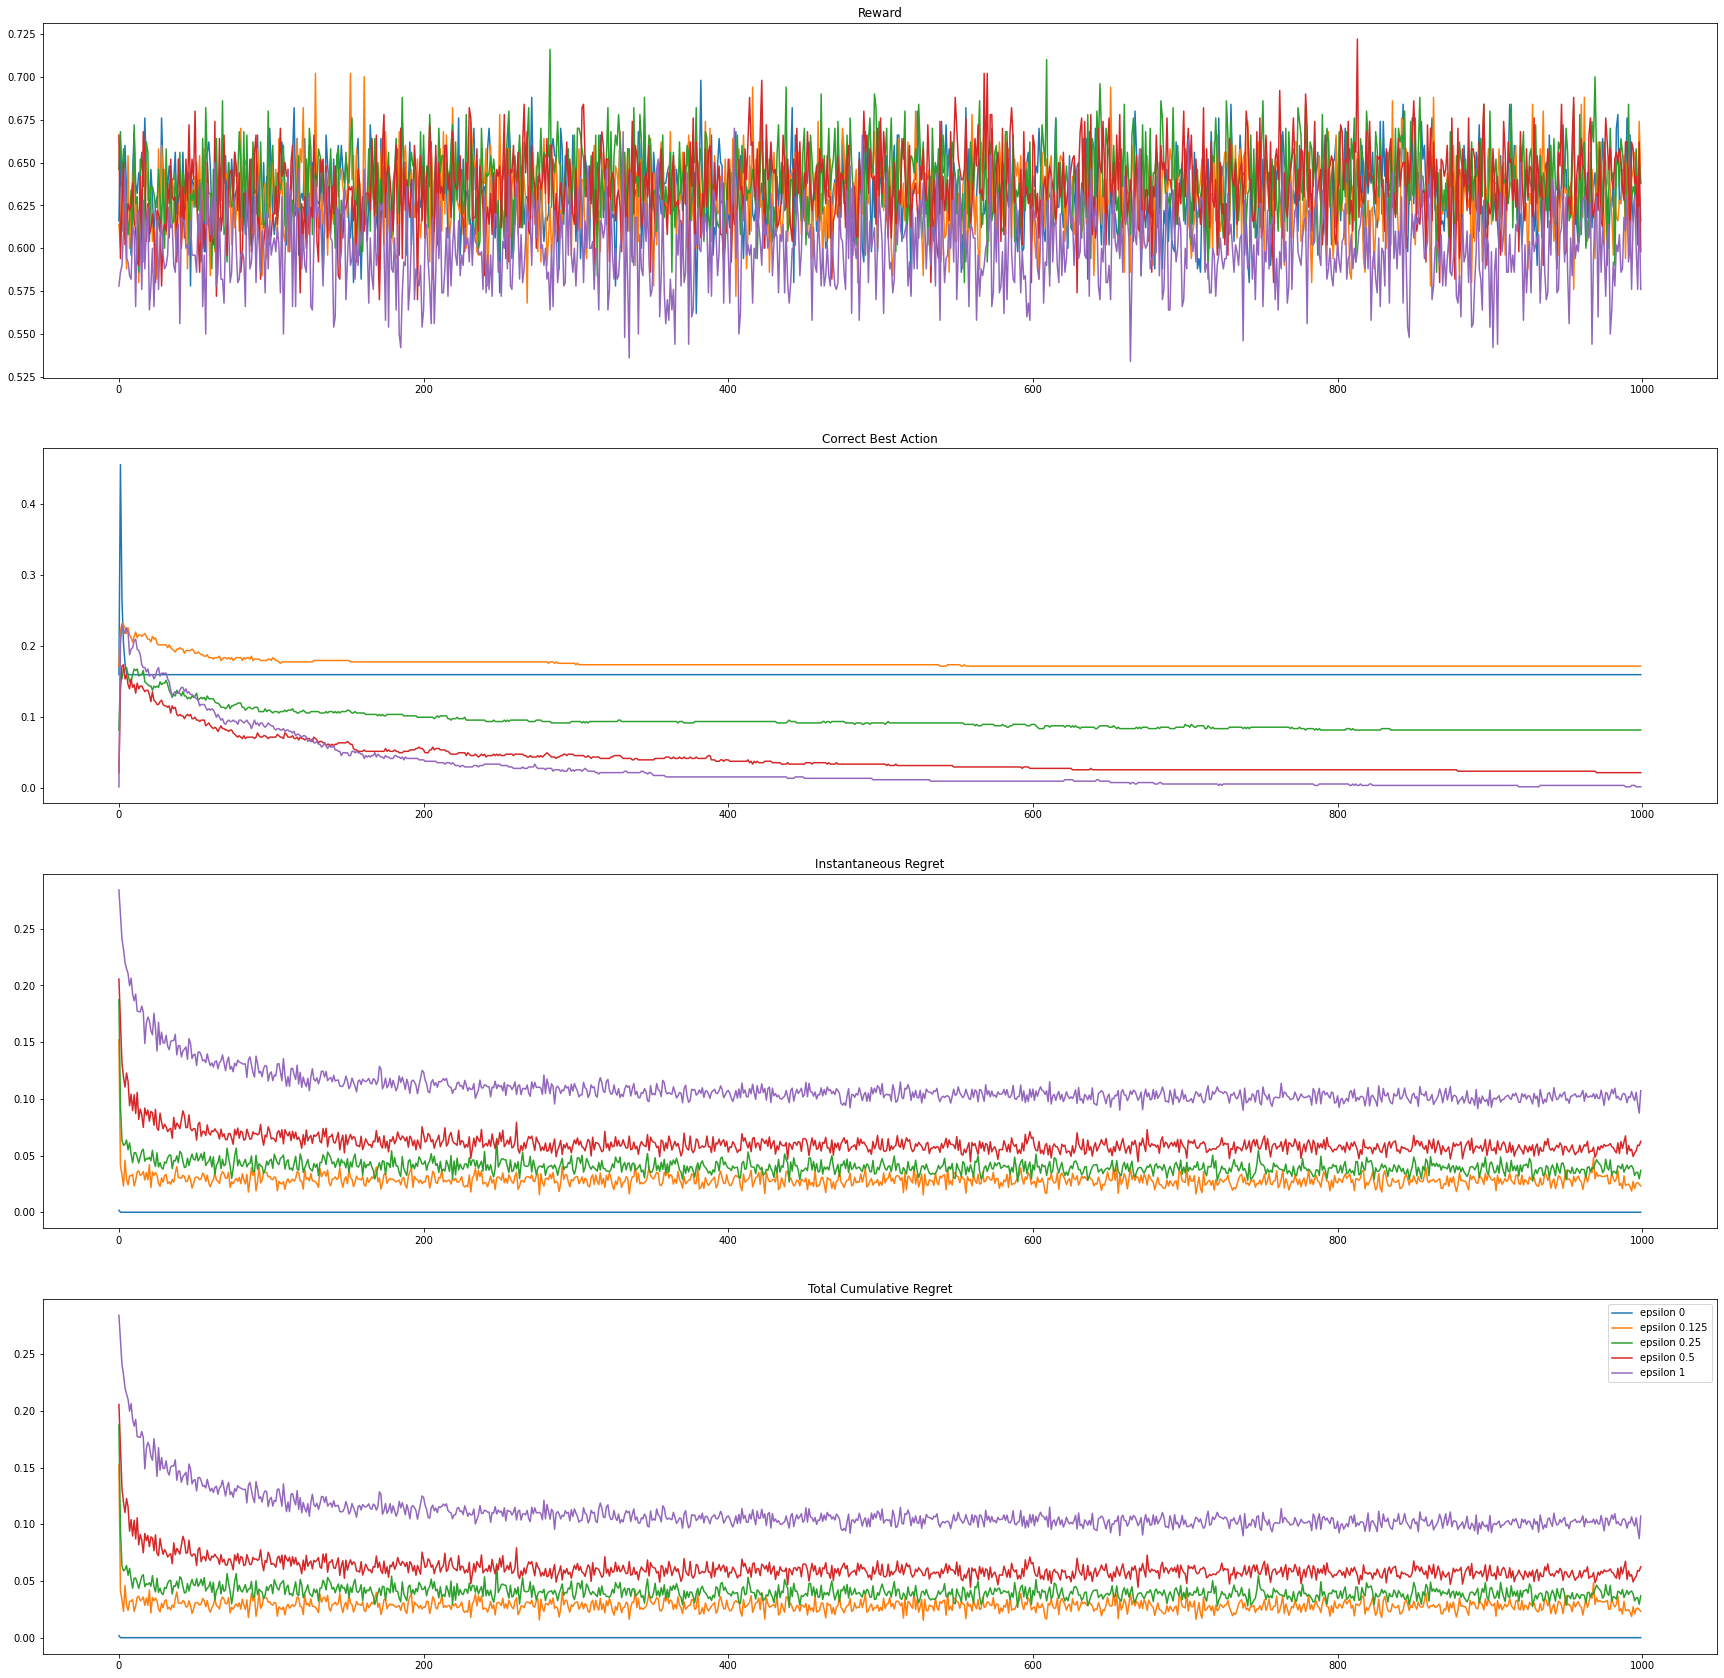

In [68]:
plots = len(epsilons)
time = np.arange(steps)

figure, axis = plt.subplots(4,1, figsize=(30,30))

for epsilon in epsilons:
  resultsavg, optrateavg, regretavg, totalregretavg = greedyrun(steps, runs, epsilon)
  axis[0].plot(time, resultsavg) 
  axis[1].plot(time, optrateavg) 
  axis[2].plot(time, regretavg) 
  axis[3].plot(time, regretavg, label='epsilon '+str(epsilon))

axis[0].set_title("Reward")
axis[1].set_title("Correct Best Action")
axis[2].set_title("Instantaneous Regret")
axis[3].set_title("Total Cumulative Regret")

plt.legend()
plt.show()

If we look closely at the Reward plot, we observe that the epsilon 1 / purple and epsilon 0 / blue reward curves are consistently lower than the others. This suggest that pure exploration and pure exploitation are both nonoptimal strategies.

In the Correct Best Action plot, the best epsilon / curve changes often at every running of the code. However, we may deduce that generally speaking, exploration (epsilon > 0) allows the model to fairly assess the action value of each option without being affected by initial "luck" in any arbitrary action.

In the Instantaneous Regret plot, the regret is understandably inverse to its epsilon, as a higher tendency to explore leads to a larger chance that the model performs an action it didn't believe to be the best.

This goes the same for the Total Regret plot. However, as we know, the model's perceived instantaneous/total regret is different from its true "distance" from performing the best actions, and so we conclude that the first two plots, Reward and Correct Best Action, provide a better overview of one important factor in K-Arm Bandits, which is a reasonable propensity for it to explore.

# Q5. Alphas + Epsilons

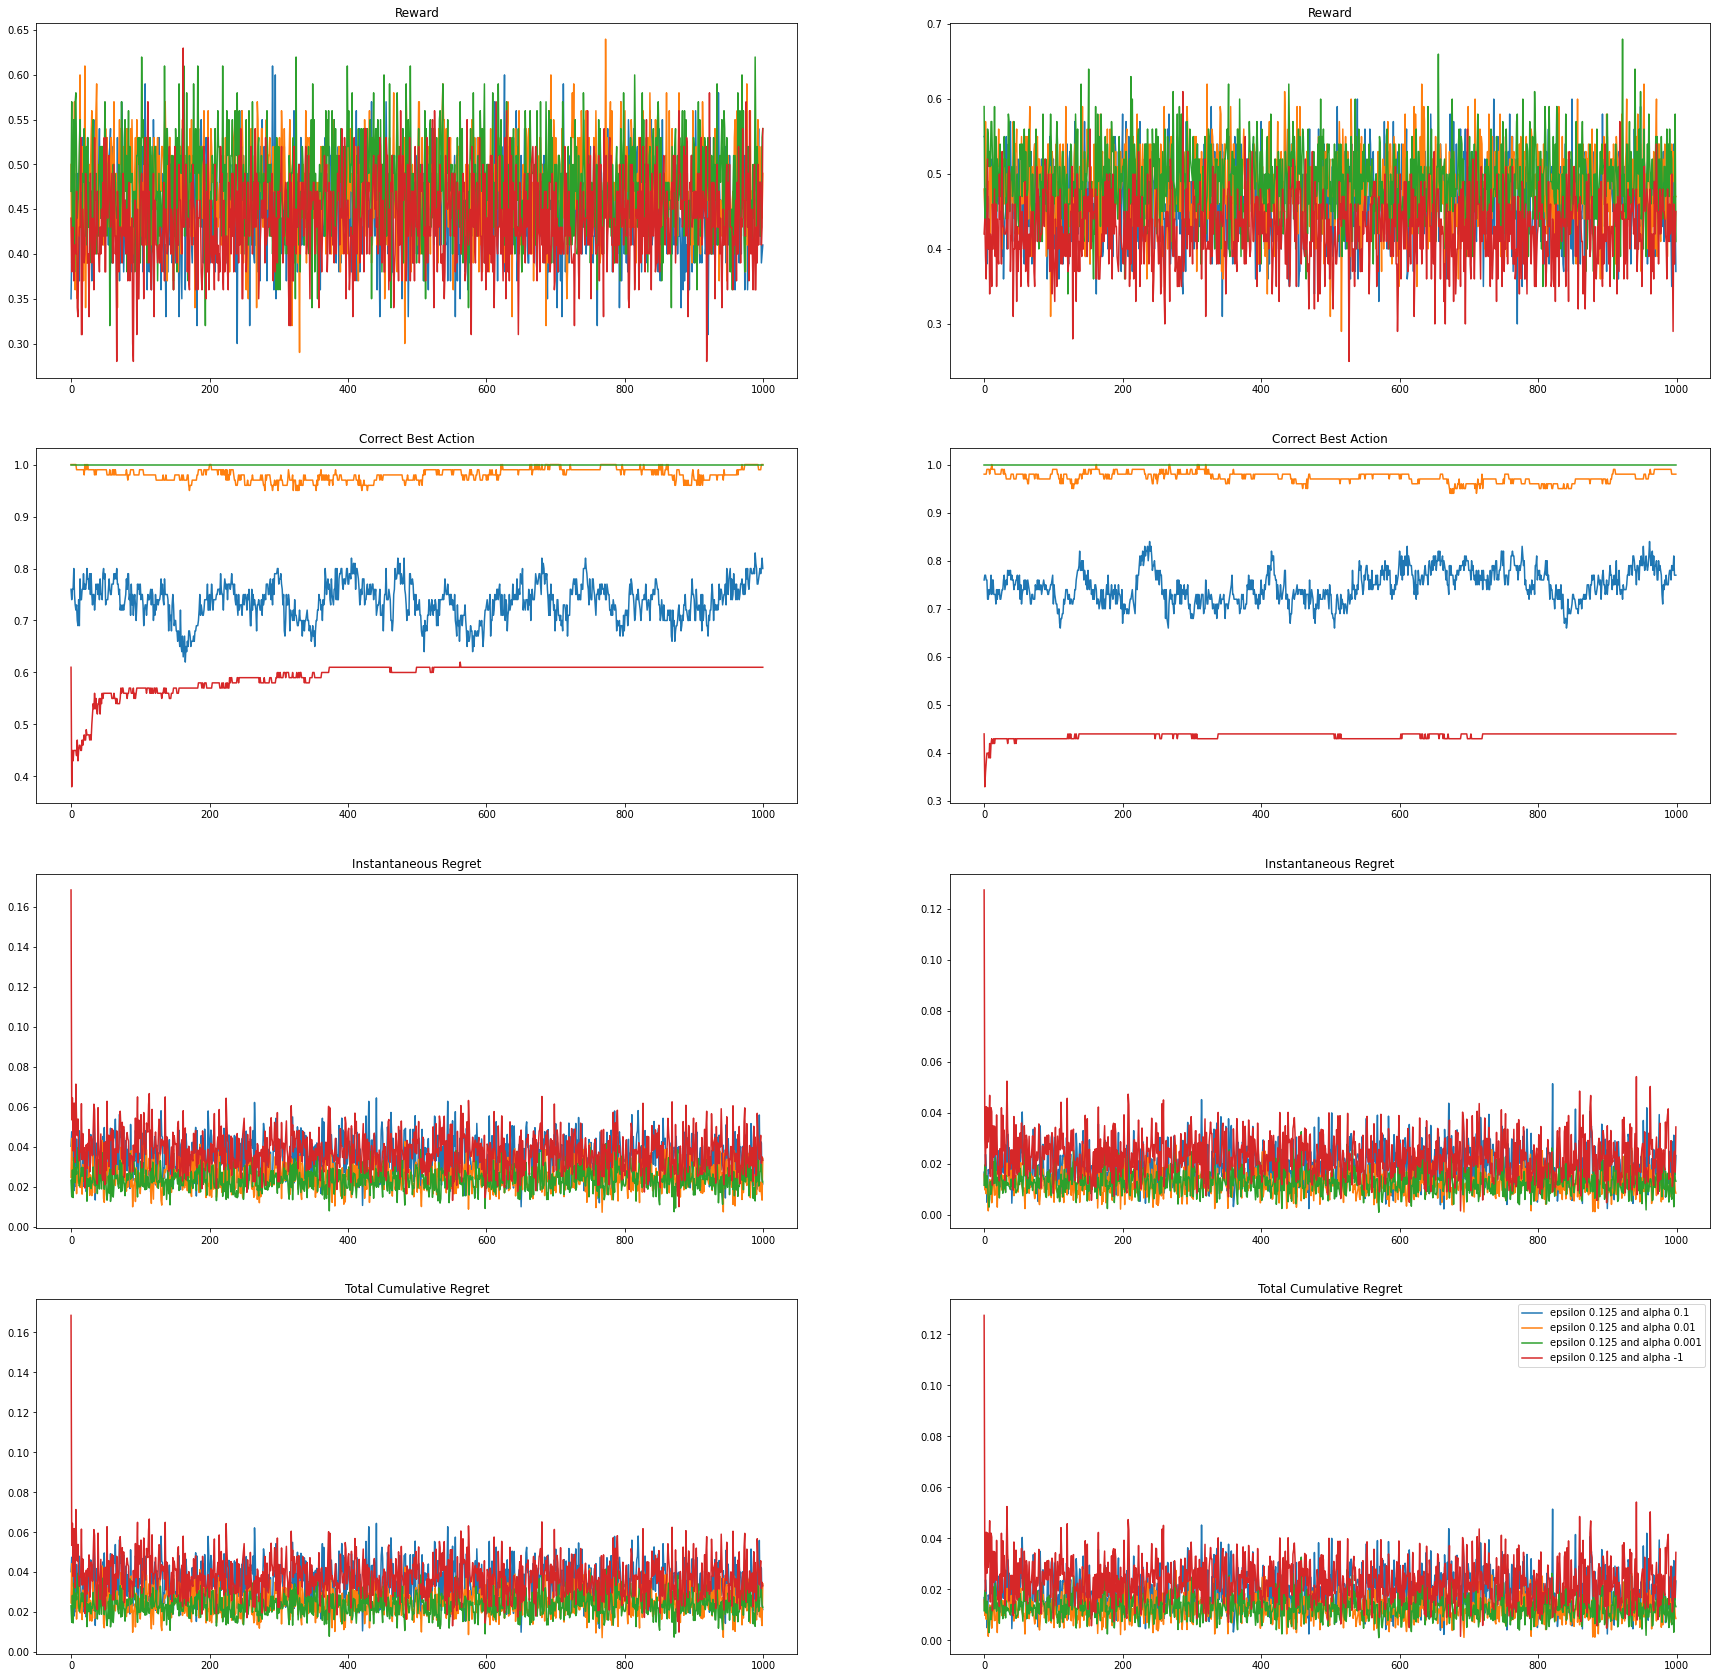

In [48]:
# QUESTION 5

epsilons2 = [1/4, 1/8]
alphas = [0.1, 0.01, 0.001, -1]
plots = len(epsilons2)
time = np.arange(steps)

figure, axis = plt.subplots(4,2, figsize=(30,30))

for i, epsilon in enumerate(epsilons2):
  for alpha in alphas:
    resultsavg, optrateavg, regretavg, totalregretavg = greedyrun(steps, runs, epsilon, alpha)
    axis[0,i].plot(time, resultsavg) 
    axis[1,i].plot(time, optrateavg) 
    axis[2,i].plot(time, regretavg) 
    axis[3,i].plot(time, regretavg, label='epsilon '+str(epsilon)+' and alpha '+str(alpha))
  axis[0,i].set_title("Reward")
  axis[1,i].set_title("Correct Best Action")
  axis[2,i].set_title("Instantaneous Regret")
  axis[3,i].set_title("Total Cumulative Regret")

plt.legend()
plt.show()

From this one visualization, we might start to observe a beneficial role that alpha plays with respect to epsilon. More specifically, the lower the epsilon, the worse normal action-value averaging performs in general, and conversely, the better a recency-weighted averaging performs.

This is best shown through the observation of the gap between alpha -1 (i.e normal averaging) and alpha 0.1 curves between epsilons 1/4 and 1/8 plots.



#Q6. UCB

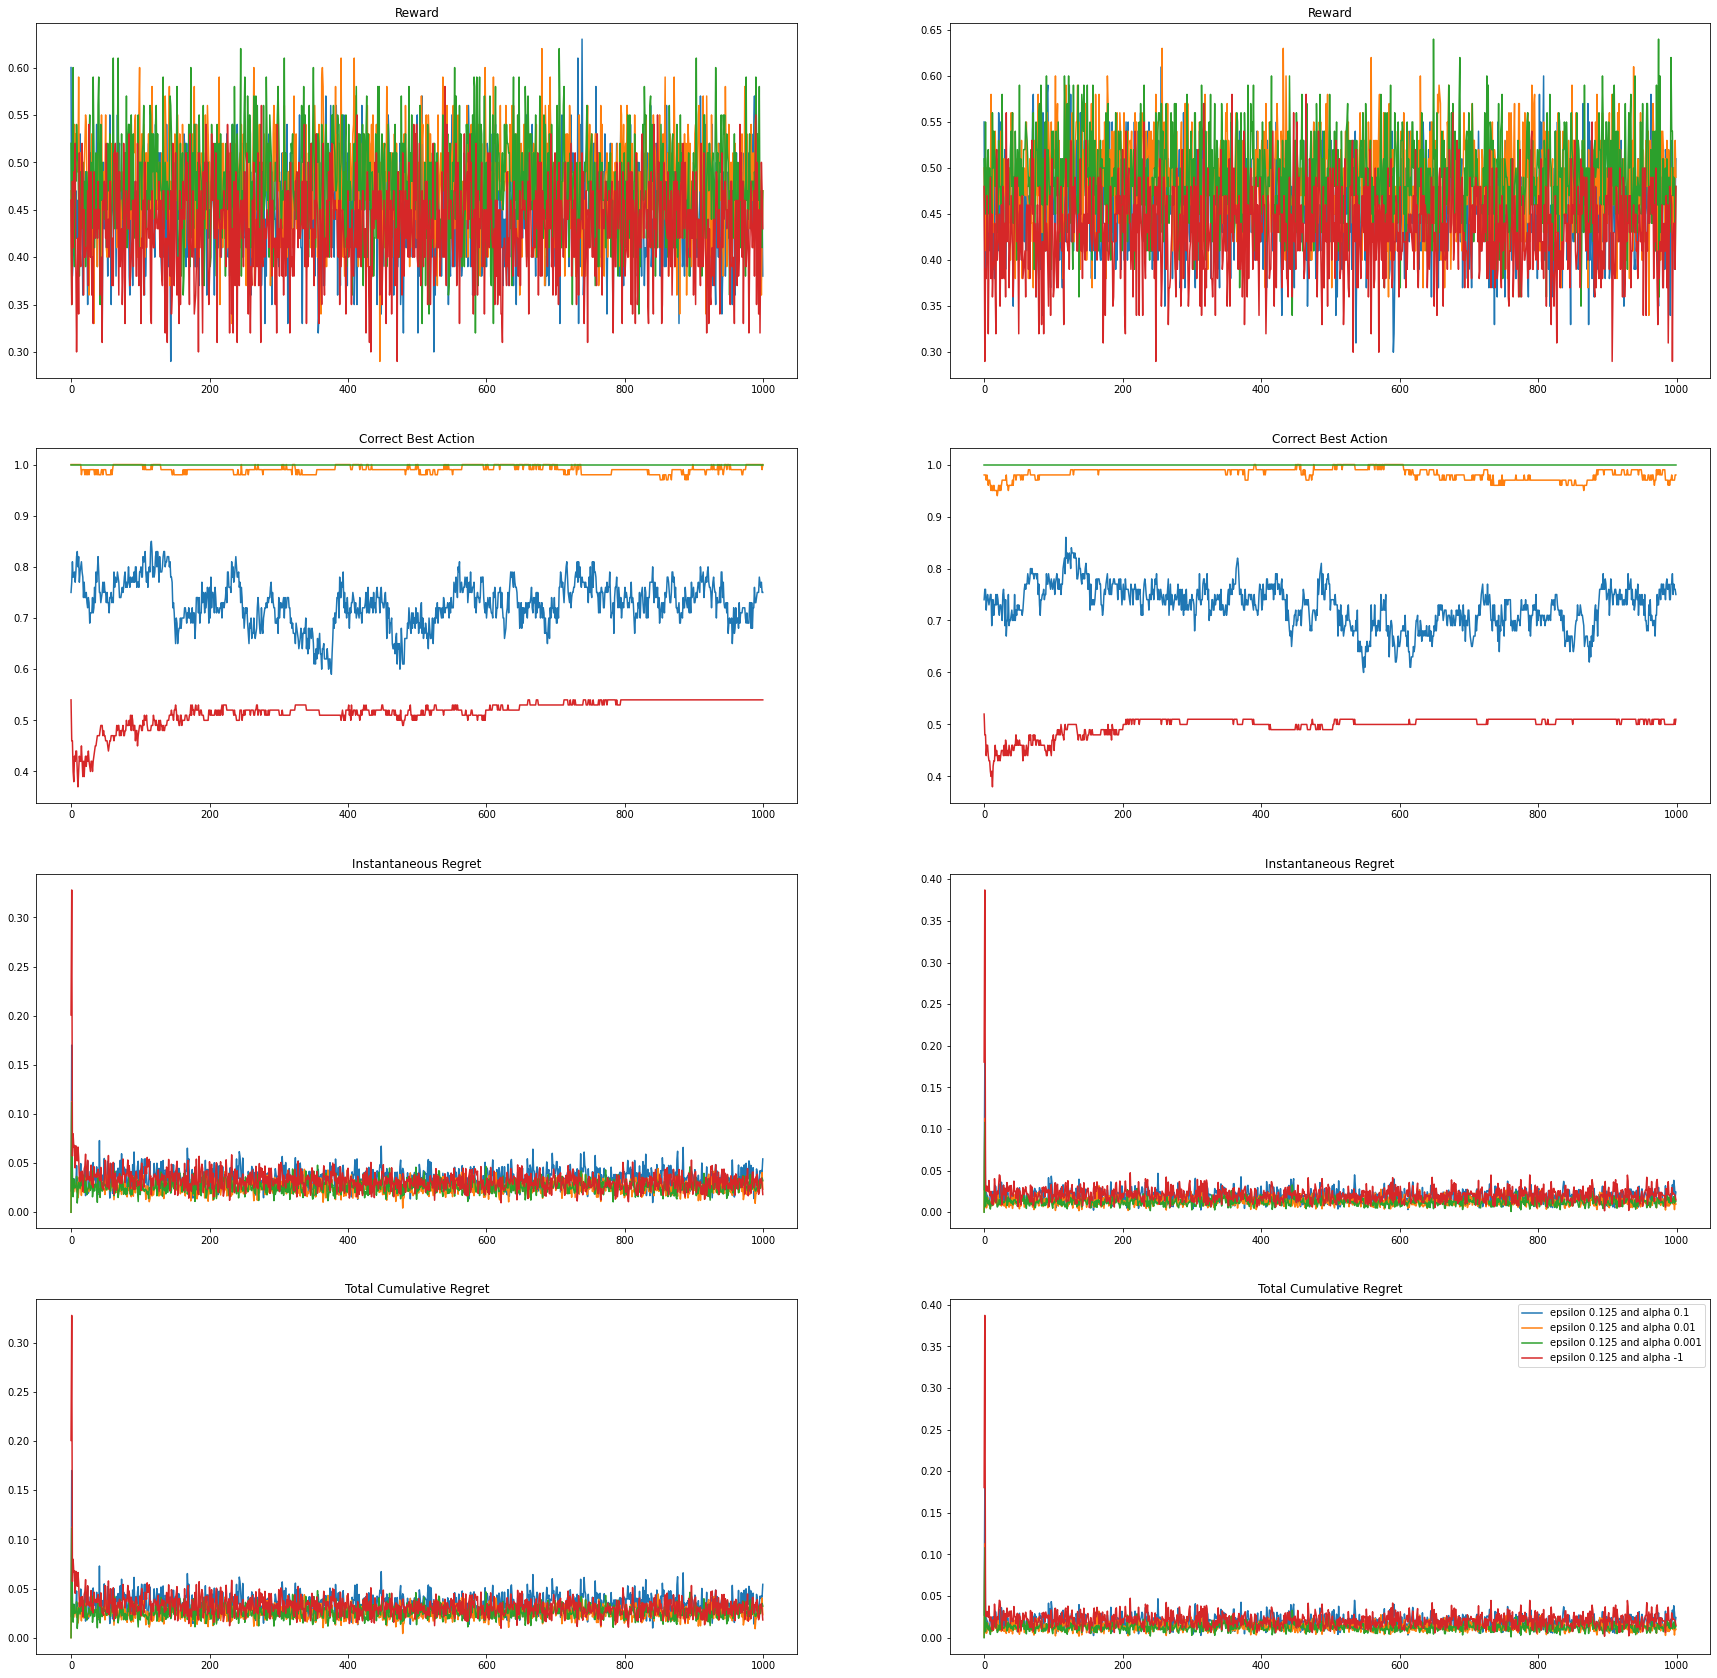

In [49]:
# QUESTION 6 

epsilons2 = [1/4, 1/8]
alphas = [0.1, 0.01, 0.001, -1]
plots = len(epsilons2)
time = np.arange(steps)

figure, axis = plt.subplots(4,2, figsize=(30,30))

for i, epsilon in enumerate(epsilons2):
  for alpha in alphas:
    resultsavg, optrateavg, regretavg, totalregretavg = greedyrun(steps, runs, epsilon, alpha, c=2)
    axis[0,i].plot(time, resultsavg) 
    axis[1,i].plot(time, optrateavg) 
    axis[2,i].plot(time, regretavg) 
    axis[3,i].plot(time, regretavg, label='epsilon '+str(epsilon)+' and alpha '+str(alpha))
  axis[0,i].set_title("Reward")
  axis[1,i].set_title("Correct Best Action")
  axis[2,i].set_title("Instantaneous Regret")
  axis[3,i].set_title("Total Cumulative Regret")

plt.legend()
plt.show()

UCB performs a similar role as E-Greedy, as it gives the k-arm bandits a bias or propensity respectively to explore previously lesser performed actions. 

Here, we observe a significant decrease in regret (both instantaneous and total), and suggest that this is due to UCB's perceived inflated value (used in the subtraction leading to regret) of lesser performed actions, which are more often than not the suboptimal ones. The tradeoff here is that the model performs these actions less because they are suboptimal, but its rarer performance of these actions, by the UCB, makes such actions more valuable to perform. This almost "smoothens" the variance between the perceived action-values.

# Q7. Thompson Sampling

Note: we omitted UCB from this trial

In [53]:
# QUESTION 7

# for value action update, we update theta

steps = 1000
runs = 100
epsilons = [0, 1/8, 1/4, 1/2, 1]

def thompsonrun(steps, runs, epsilon, alpha=-1):
  resultsavg = np.zeros(steps)
  optrateavg = np.zeros(steps)
  regretavg = np.zeros(steps)

  for run in range(runs):
    results, optrate, regret = model.thompson(steps, epsilon, alpha)
    resultsavg += results
    optrateavg += optrate
    regretavg += regret

  resultsavg /= runs
  optrateavg /= runs
  regretavg /= runs

  totalregretavg = regretavg.cumsum() / (np.arange(steps) + 1)

  return resultsavg, optrateavg, regretavg, totalregretavg

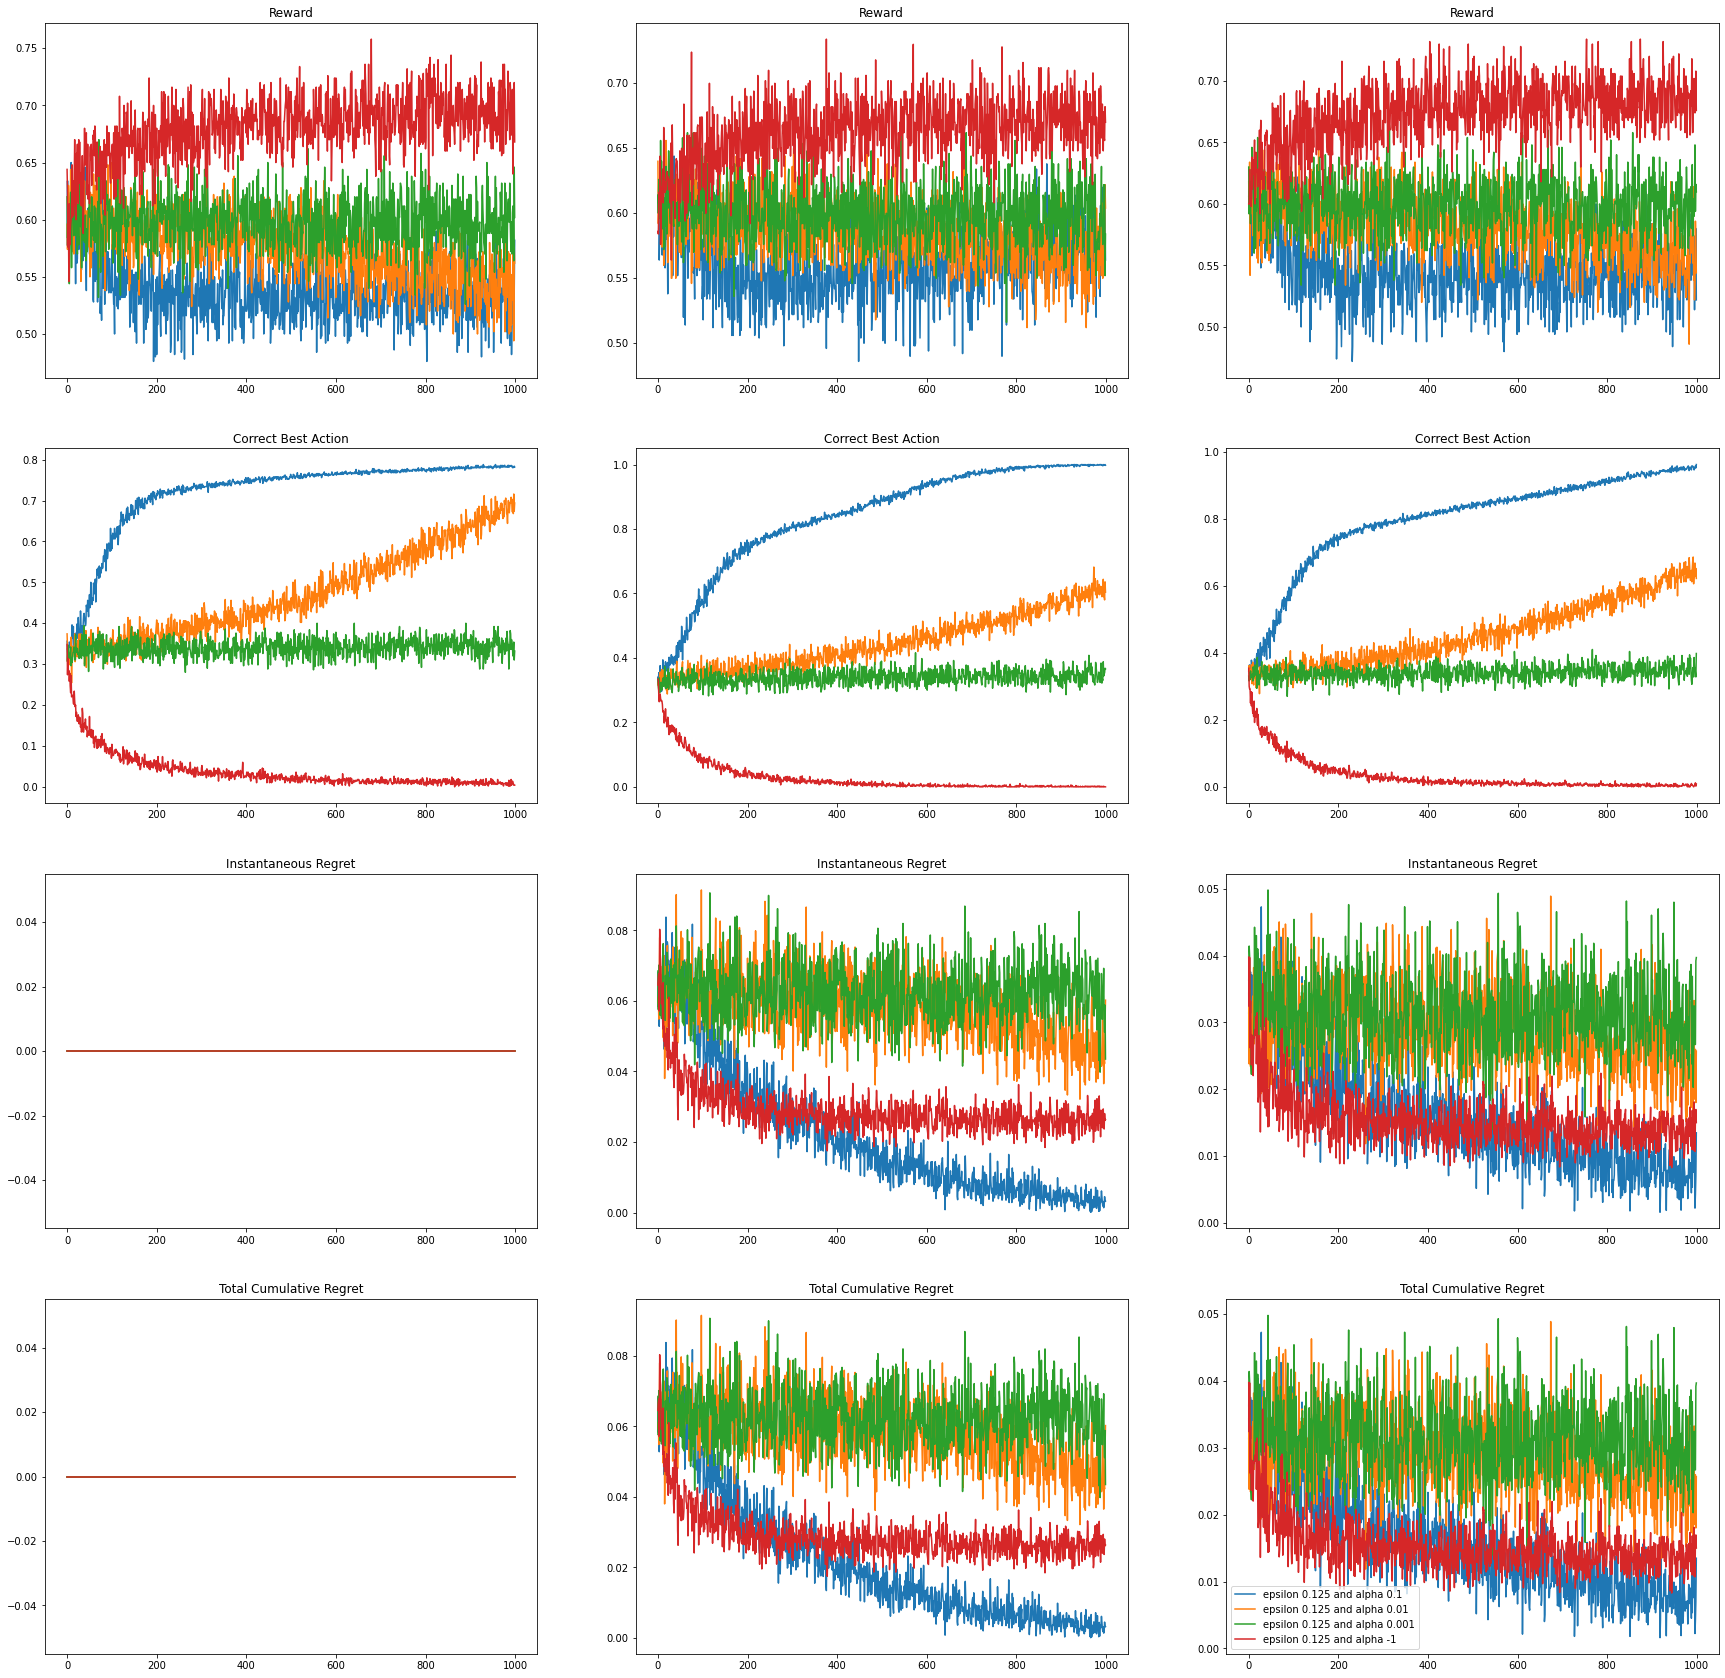

In [69]:
epsilons2 = [0, 1/4, 1/8]
alphas = [0.1, 0.01, 0.001, -1]
plots = len(epsilons2)
time = np.arange(steps)

figure, axis = plt.subplots(4,3, figsize=(30,30))

for i, epsilon in enumerate(epsilons2):
  for alpha in alphas:
    resultsavg, optrateavg, regretavg, totalregretavg = thompsonrun(steps, runs, epsilon, alpha)
    axis[0,i].plot(time, resultsavg) 
    axis[1,i].plot(time, optrateavg) 
    axis[2,i].plot(time, regretavg) 
    axis[3,i].plot(time, regretavg, label='epsilon '+str(epsilon)+' and alpha '+str(alpha))
  axis[0,i].set_title("Reward")
  axis[1,i].set_title("Correct Best Action")
  axis[2,i].set_title("Instantaneous Regret")
  axis[3,i].set_title("Total Cumulative Regret")

plt.legend()
plt.show()

From Thompson sampling, we observe that a lower to null epsilon leads to the best performance in reward, correct best action, and regret. This is because Thompson sampling plays a similar role as the E-Greedy algorithm, meaning it makes a choice based on its previous success/fail rate per action while incorporating a slight amount of randomness/uncertainty through the Beta distribution, giving it the occasional chances to explore. 

We suggest that conceptually, Thompson sampling performs better than E-Greedy as the randomness/uncertainty is "proportional" (through the Beta parameters) to its success/fail experience with a given action, which results in a more nuanced and fairly assessed decision, rather than "randomly" picking a decision with epsilon probability.

Here, the three columns of plots are at epsilon = 0, 1/4, 1/8 respectively, and we observe that a larger epsilon at 1/4 more correctly makes the right decision. Moreove, alpha = 0.1 consistently performs the best on all metrics.

In [60]:
np.concatenate((resultsavg,resultsavg),axis=0)

array([0.602, 0.632, 0.626, ..., 0.646, 0.71 , 0.668])

#Q8. Best Hyperparameters

From the above, we observe the best alpha and epsilon for each algorithm:
*   E-Greedy: 0.01, 0.125 *(0.001 looked "too good")*
*   UCB w/ E-Greedy: 0.01, 0.125 *(same comment)*
*   Thompson




Text(0.5, 1.0, 'Total Cumulative Regret')

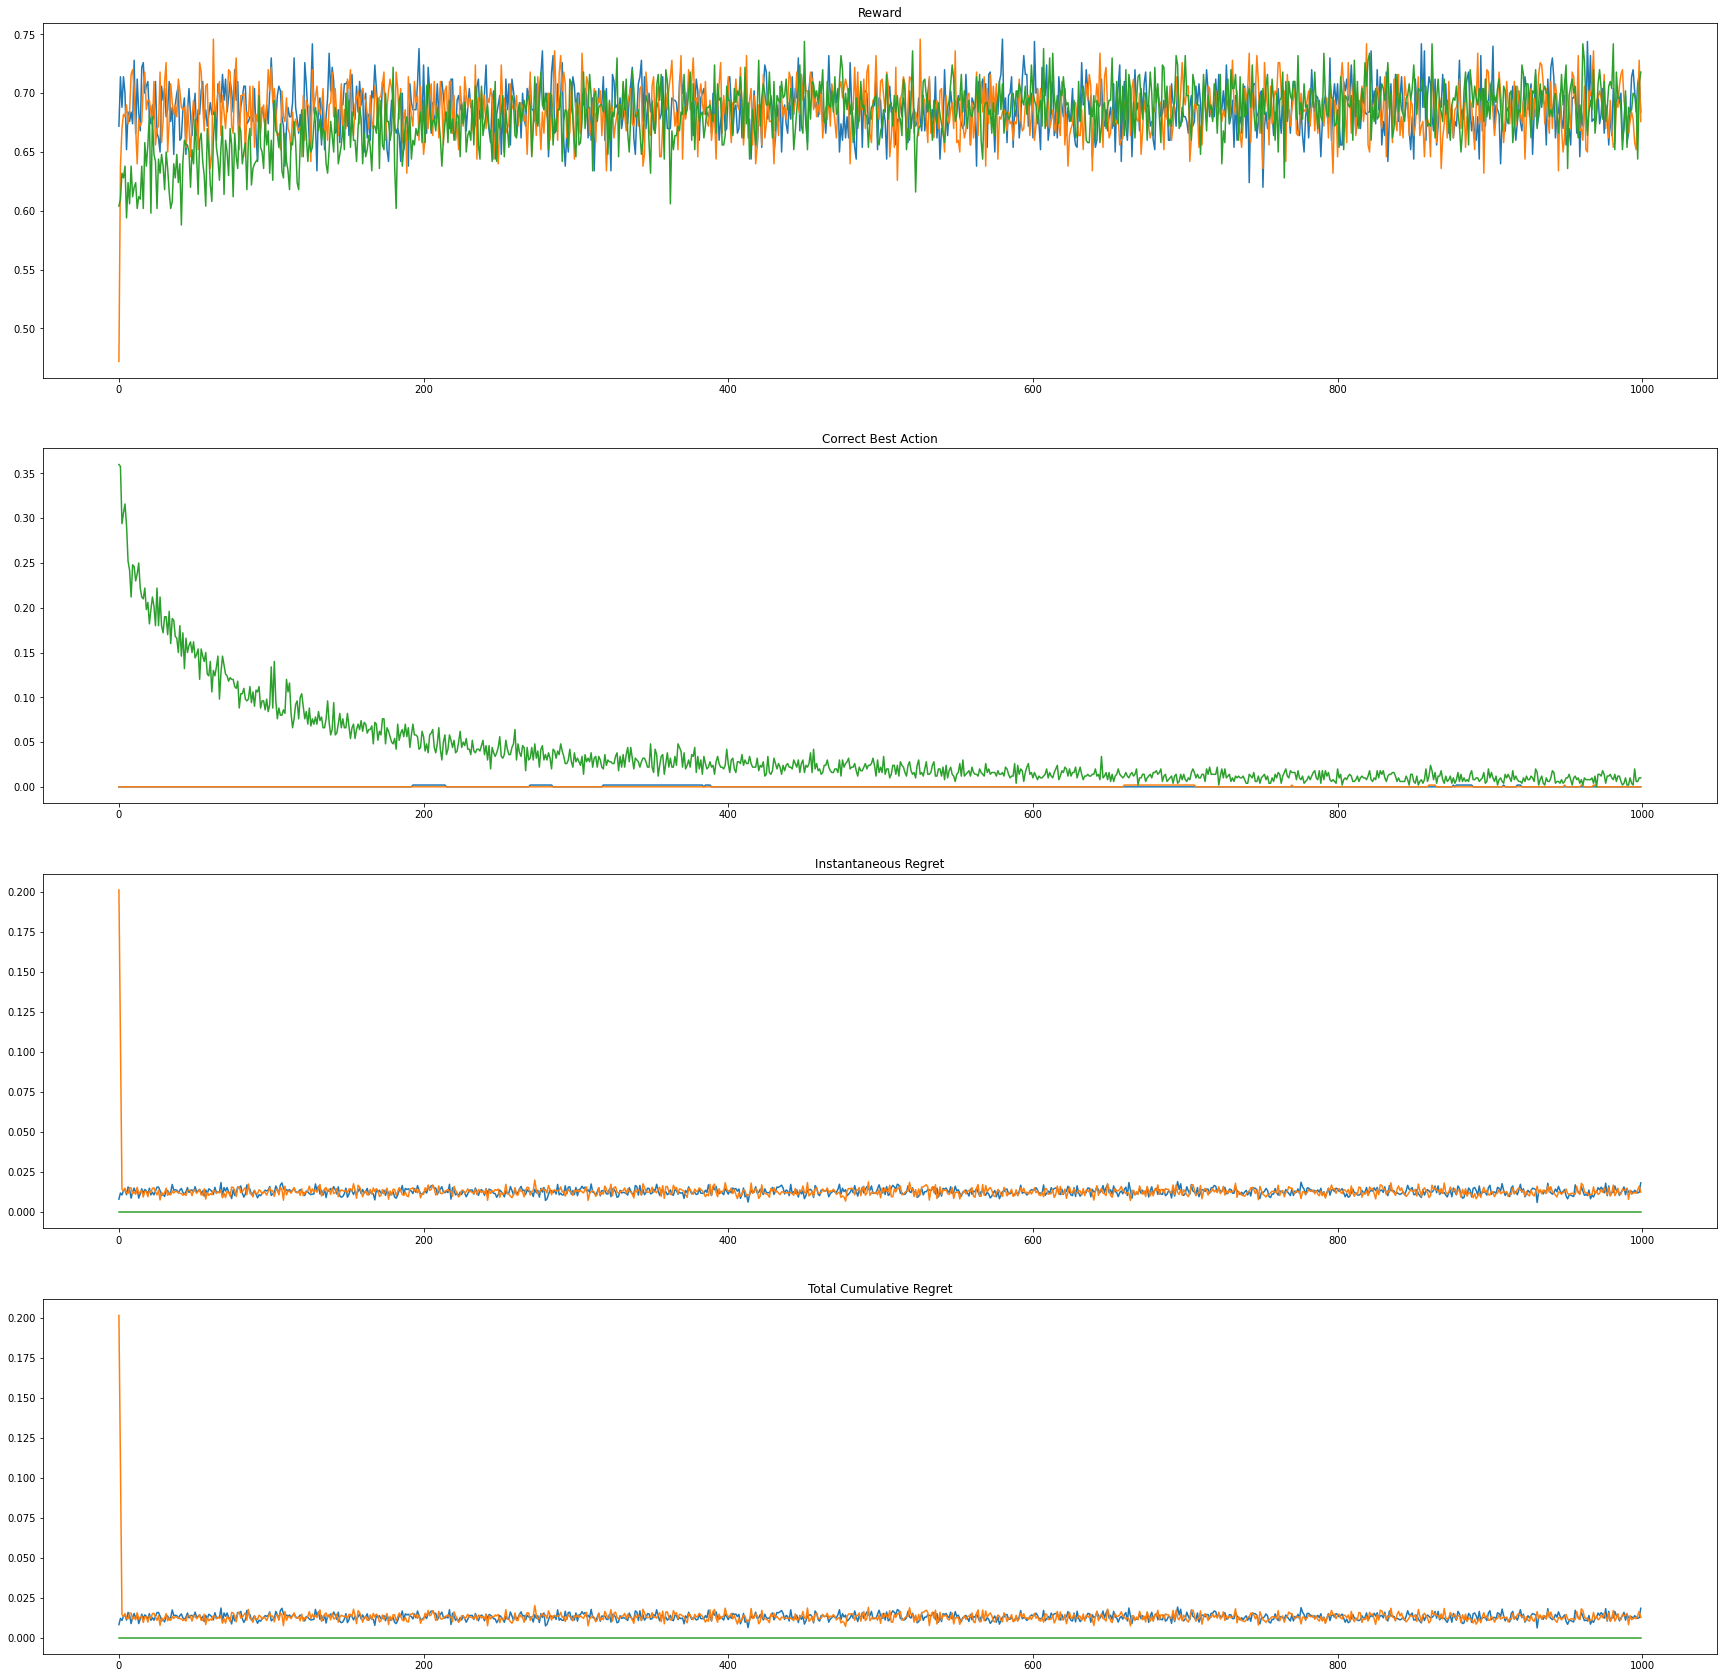

In [74]:
steps = 1000

time = np.arange(steps)

figure, axis = plt.subplots(4,1, figsize=(30,30))

alpha = 0.01

# E-Greedy

resultsavg1, optrateavg1, regretavg1, totalregretavg1 = greedyrun(steps, runs, 0.125, alpha)
axis[0].plot(time, resultsavg1) 
axis[1].plot(time, optrateavg1) 
axis[2].plot(time, regretavg1) 
axis[3].plot(time, regretavg1, label='greedy, epsilon '+str(epsilon)+' and alpha '+str(alpha))

# UCB w/ E-Greedy

resultsavg2, optrateavg2, regretavg2, totalregretavg2 = greedyrun(steps, runs, 0.125, alpha, c=2)
axis[0].plot(time, resultsavg2) 
axis[1].plot(time, optrateavg2) 
axis[2].plot(time, regretavg2) 
axis[3].plot(time, regretavg2, label='ucb, epsilon '+str(epsilon)+' and alpha '+str(alpha))

# Thompson

resultsavg3, optrateavg3, regretavg3, totalregretavg3 = thompsonrun(steps, runs, 0)
axis[0].plot(time, resultsavg3) 
axis[1].plot(time, optrateavg3) 
axis[2].plot(time, regretavg3) 
axis[3].plot(time, regretavg3, label='thompson')

axis[0].set_title("Reward")
axis[1].set_title("Correct Best Action")
axis[2].set_title("Instantaneous Regret")
axis[3].set_title("Total Cumulative Regret")

Here, we observe that all metrics perform approximately the same, but Thompson sampling is initially inaccurate in choosing the best action, although it does quickly converge to similar rewards, correction best actions, and regret.

# Q9. Non-Stationarity

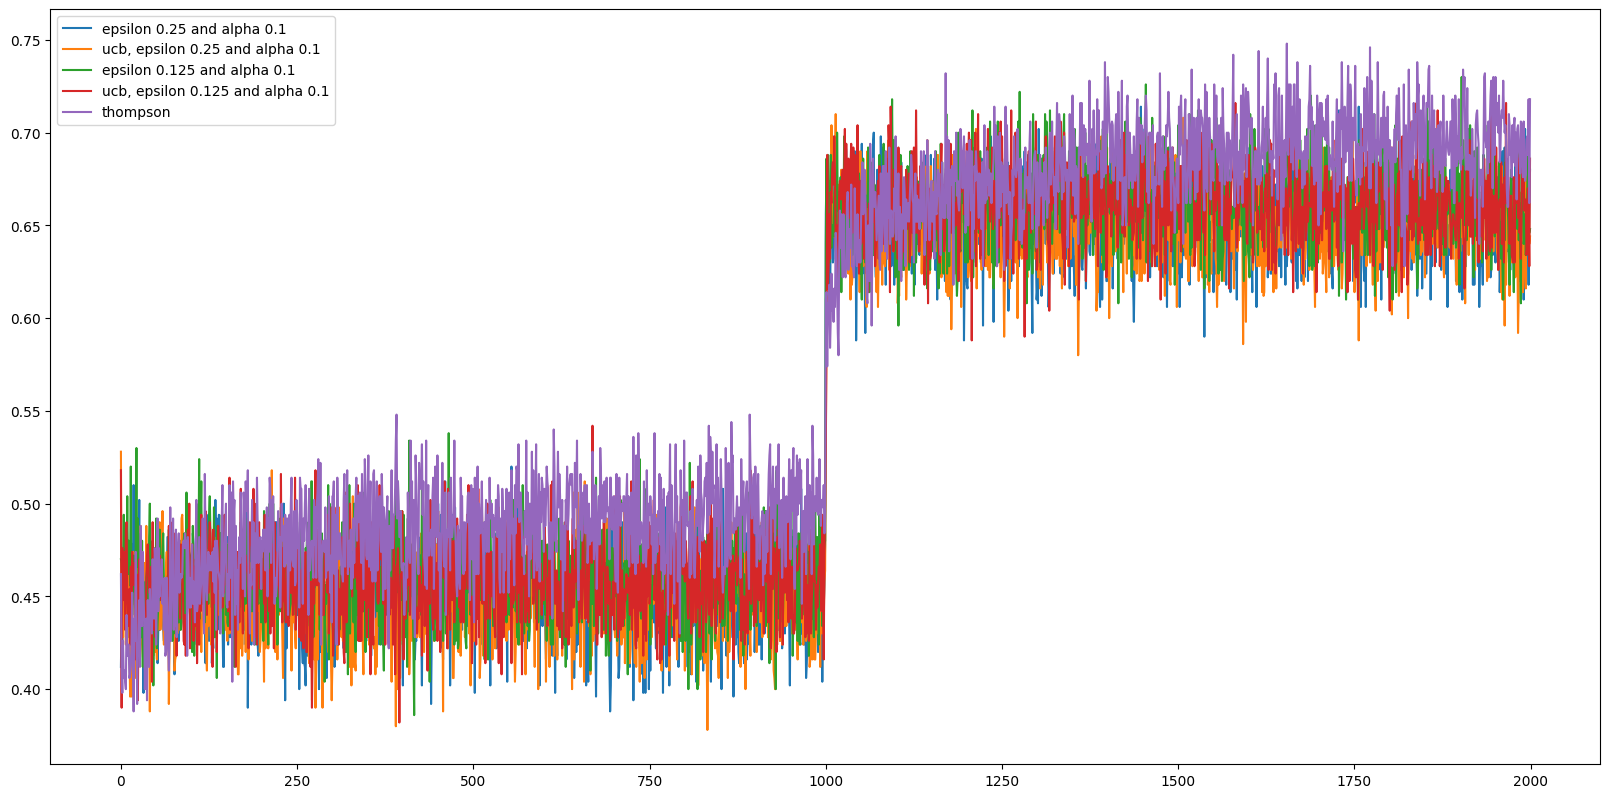

In [66]:
# QUESTION 9, we let p = [0.5, 0.6, 0.7] after 500 time steps (halfway)

from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=100)

epsilons3 = [1/4, 1/8]
alpha = 0.1
time = np.arange(steps*2)

runs = 500 # half of the total number of runs

for epsilon in epsilons3:

  model.rewards = np.zeros((model.k))
  model.explored = np.ones((model.k))
  model.p = np.array([0.5, 0.4, 0.3])
  resultsavg1, optrateavg, regretavg, totalregretavg = greedyrun(steps, runs, epsilon, alpha)
  model.p = np.array([0.5, 0.6, 0.7])
  resultsavg2, optrateavg, regretavg, totalregretavg = greedyrun(steps, runs, epsilon, alpha)
  resultsavg = np.concatenate((resultsavg1, resultsavg2), axis=0)
  plt.plot(time, resultsavg, label='epsilon '+str(epsilon)+' and alpha '+str(alpha))

  model.rewards = np.zeros((model.k))
  model.explored = np.ones((model.k))
  model.p = np.array([0.5, 0.4, 0.3])
  resultsavg1, optrateavg, regretavg, totalregretavg = greedyrun(steps, runs, epsilon, alpha, c=2)
  model.p = np.array([0.5, 0.6, 0.7])
  resultsavg2, optrateavg, regretavg, totalregretavg = greedyrun(steps, runs, epsilon, alpha, c=2)
  resultsavg = np.concatenate((resultsavg1, resultsavg2), axis=0)
  plt.plot(time, resultsavg, label='ucb, epsilon '+str(epsilon)+' and alpha '+str(alpha))


model.p = np.array([0.5, 0.4, 0.3])
resultsavg1, optrateavg, regretavg, totalregretavg = thompsonrun(steps, runs, epsilon=0, alpha=-1) # no epsilon nor alpha
model.p = np.array([0.5, 0.6, 0.7])
resultsavg2, optrateavg, regretavg, totalregretavg = thompsonrun(steps, runs, epsilon=0, alpha=-1) # no epsilon nor alpha
resultsavg = np.concatenate((resultsavg1, resultsavg2), axis=0)
plt.plot(time, resultsavg, label='thompson')

plt.legend()
plt.show()

Here, we observe that Thompson does the best. This goes against our initial assumptions, because we assumed that the alpha for recency-weighting would mitigate the effects of non-stationarity through giving a larger weight to the most recently observed rewards.

This is further shown through an observation of Thompson sampling's curve once the probabilities change, where we see an initially low reward after 1000 time steps, followed by a quick ascent above the other curves. We conclude that this is a property of the Beta distribution, which must be sensitive to the ratio of successes and fails (which are its parameters) per action.